# Analyze the results from calculating background numbers for all configs

## July 20th

I performed a scan (~1000 times) scrambling the position of the source for a fixed SNR cut (starting with diffuse cut), and calculated the number of events that passed all cuts, then this result was averaged by the number of times the scrambling was done. We'd like to lower the SNR cut until we get a number of backgrounds similar to that obtained in the diffuse analysis.

I had to re-run imposing a new cut, since the files that Brian gave me have an outdated version of the cut

In [1]:
import sys
sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd


Welcome to JupyROOT 6.18/04


In [2]:
f = ROOT.TFile.Open("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/files/source_optimization/c1/bkg_random_SNR_scan_config1.root")
f.ls()
tree = f.Get("SNR_scan_c1")
tree.Print()


TFile**		/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/files/source_optimization/c1/bkg_random_SNR_scan_config1.root	
 TFile*		/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/files/source_optimization/c1/bkg_random_SNR_scan_config1.root	
  KEY: TTree	SNR_scan_c1;1	SNR_scan_c1
  KEY: TH2D	;1	H Data
******************************************************************************
*Tree    :SNR_scan_c1: SNR_scan_c1                                            *
*Entries :      510 : Total =           75840 bytes  File  Size =      52758 *
*        :          : Tree compression factor =   1.31                       *
******************************************************************************
*Br    0 :phi       : phi/D                                                  *
*Entries :      510 : Total  Size=      14279 bytes  File Size  =      11934 *
*Baskets :      102 : Basket Size=      32000 bytes  Compression=   1.00     *
*...............................................

In [3]:
phi = tree.AsMatrix(["theta"]).ravel()
theta = tree.AsMatrix(["phi"]).ravel()
numPassAll = []
SNR_intercept = []
tree.GetEvent(0)
SNR_intercept = np.array(tree.SNR_intercept).reshape(6,4)[:,0]
for i in range(0, tree.GetEntries()):
    tree.GetEvent(i)
    numPassAll.append(np.array(tree.numPassAll).reshape(6,4)[:,0])# PyROOT still hasn't implemented the easy way
    #for arrays

In [4]:
# colNames = ["phi", 'theta'] + ["%.1f" % x for x in SNR_intercept]
colNames = ["%.1f" % x for x in SNR_intercept]
colNames

['20.0', '19.5', '19.0', '18.5', '18.0', '17.5']

In [5]:
# phi = np.array(phi).ravel()
d1 = pd.DataFrame(data=numPassAll, columns=colNames)
means = pd.DataFrame(data=d1.mean(), columns=["bkg"]).reset_index()
means = means.sort_values(by="index")

In [6]:
d2 = {'phi': phi, 'theta': theta}
d2 = pd.DataFrame(d2)
d2.tail()

,phi,theta
505,38.723777,3.328341
506,73.933728,-16.202479
507,5.821978,-41.464889
508,-74.468194,65.475078
509,-33.597908,-156.681843


In [9]:
df = pd.concat([d2, d1], axis=1, sort=False)
# df = df.loc[df.theta<17]

Text(0,0.5,'$\\theta$')

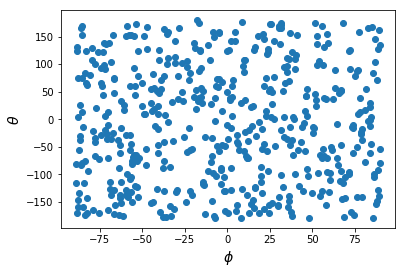

In [10]:
plt.scatter(df.phi,df.theta)
plt.xlabel("$\phi$", fontsize=14)
# plt.ylabel("$\cos(\\theta$)", fontsize=14)
plt.ylabel("$\\theta$", fontsize=14)

In [11]:
means["index"][:-2]

5    17.5
4    18.0
3    18.5
2    19.0
Name: index, dtype: object

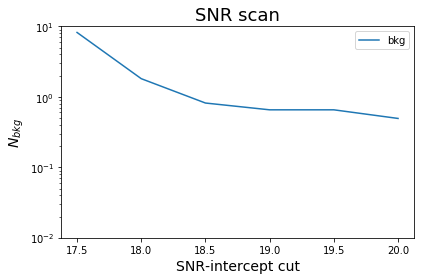

In [12]:
# plt.axhline(5E-2, ls="--", c="C1", label="Diffuse $N_{bkg}$ SNR cut = 20.6")
# plt.axvline(20.6, ls="--", c="C2", label="Diffuse SNR cut")


plt.plot(means["index"], means.bkg)
plt.yscale('log')
plt.ylim(0.01,10)
plt.xlabel("SNR-intercept cut", fontsize=14)
plt.ylabel("$N_{bkg}$", fontsize=14)
plt.title("SNR scan",fontsize=18)
plt.legend()
plt.tight_layout()
# plt.savefig("./plots/scan_yinterc_scrambled_source.png", dpi=150)

### Loop over configs

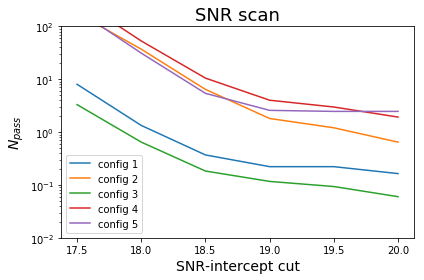

In [15]:
for j in range(1,6):
    f = ROOT.TFile.Open("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/files/source_optimization/c%i/bkg_random_SNR_scan_config%i.root"%(j,j))
    tree = f.Get("SNR_scan_c%i"%j)
    theta = tree.AsMatrix(["theta"]).ravel()
    phi = tree.AsMatrix(["phi"]).ravel()
    numPassAll = []
    SNR_intercept = []
    tree.GetEvent(0)
    SNR_intercept = np.array(tree.SNR_intercept).reshape(6,4)[:,0]
    for i in range(0, tree.GetEntries()):
        tree.GetEvent(i)
        numPassAll.append(np.array(tree.numPassAll).reshape(6,4)[:,0])# PyROOT still hasn't implemented the easy way
        #for arrays
    d1 = pd.DataFrame(data=numPassAll, columns=colNames)
    d2 = {'phi': phi, 'theta': theta}
    d2 = pd.DataFrame(d2)
    df = pd.concat([d2, d1], axis=1, sort=False)
    df = df.loc[df .theta<17]    
    means = pd.DataFrame(data=df.mean(), columns=["bkg"]).reset_index()
    means = means.sort_values(by="index")
    plt.plot(means["index"][:-2], means.bkg[:-2], label = "config %i"%j)
plt.yscale('log')
plt.ylim(0.01,100)
plt.xlabel("SNR-intercept cut", fontsize=14)
plt.ylabel("$N_{pass}$", fontsize=14)
plt.title("SNR scan",fontsize=18)
plt.legend()
plt.tight_layout()
# plt.savefig("./plots/scan_yinterc_scrambled_source_allConfigs.png", dpi=150)


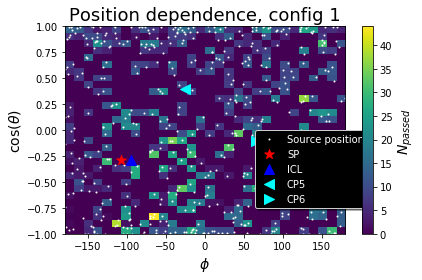

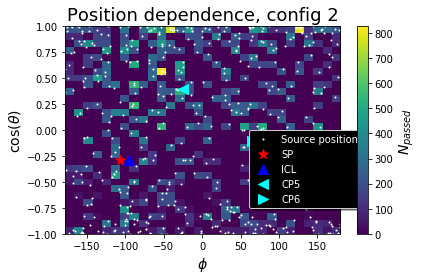

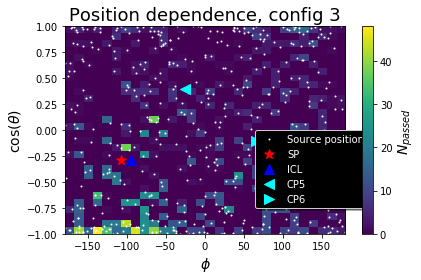

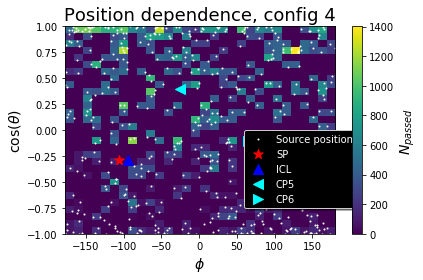

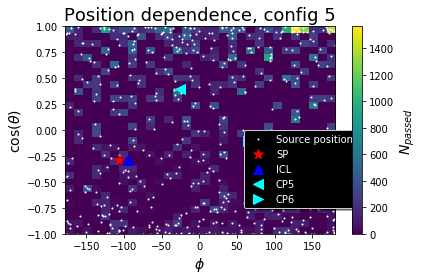

In [14]:
for j in range(1,6):
    f = ROOT.TFile.Open("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/files/source_optimization/c%i/bkg_random_SNR_scan_config%i.root"%(j,j))
    tree = f.Get("SNR_scan_c%i"%j)
    phi = tree.AsMatrix(["phi"]).ravel()
    theta = tree.AsMatrix(["theta"]).ravel()
    numPassAll = []
    SNR_intercept = []
    tree.GetEvent(0)
    SNR_intercept = np.array(tree.SNR_intercept).reshape(6,4)[:,0]
    for i in range(0, tree.GetEntries()):
        tree.GetEvent(i)
        numPassAll.append(np.array(tree.numPassAll).reshape(6,4)[:,0])# PyROOT still hasn't implemented the easy way
        #for arrays
   
    d1 = pd.DataFrame(data=numPassAll, columns=colNames)
    d2 = {'phi': phi, 'theta': theta}
    d2 = pd.DataFrame(d2)
    df = pd.concat([d2, d1], axis=1, sort=False)
#     df = df.loc[df.theta<17]
    plt.figure()
    plt.hist2d(df.phi,np.cos(np.deg2rad(df.theta+90)), weights=df["17.5"], bins=30)
#     plt.hist2d(df.phi,df.theta, weights=df["18.0"], bins=30)
    cbar = plt.colorbar()
    cbar.set_label(label='$N_{passed}$',weight='bold', fontsize=14)
    plt.scatter(df.phi,np.cos(np.deg2rad(df.theta+90)), s=1, c="w", label = "Source position")
    plt.scatter(-106.94,np.cos(np.deg2rad(17+90)),marker = "*", s=100,c='red', label = "SP")
    plt.scatter(-94.84,np.cos(np.deg2rad(17+90)),marker = "^", s=100,c='b', label = "ICL")
    plt.scatter(-25.02,np.cos(np.deg2rad(-23.56+90)),marker = "<", s=100,c='cyan', label = "CP5")
    plt.scatter(65.19,np.cos(np.deg2rad(5.85+90)),marker = ">", s=100,c='cyan', label = "CP6")

#     plt.scatter(df.phi,df.theta, s=1, c="w", label = "Source position")
#     plt.scatter(-106.94,17,marker = "*", s=100,c='red', label = "SP")
#     plt.scatter(-94.84,17,marker = "^", s=100,c='b', label = "ICL")
#     plt.scatter(-25.02,-23.56,marker = "<", s=100,c='cyan', label = "CP5")
#     plt.scatter(65.19,5.85,marker = ">", s=100,c='cyan', label = "CP6")

    plt.xlabel("$\phi$", fontsize=14)
    plt.ylabel("$\cos(\\theta$)", fontsize=14)
    plt.title("Position dependence, config %i"%j,fontsize=18)
    legend = plt.legend(bbox_to_anchor=(1.1, 0.1), loc='lower right' , fancybox=True, facecolor='k', shadow=True)
    plt.setp(legend.get_texts(), color='w')
    plt.ylim(-1,1)
#     plt.ylim(-90,90)
    plt.tight_layout()
#     plt.savefig("./plots/pos_dependence_noSurf_c%i.png"%j, dpi=150)


## Look at angle distribution as a function of background estimates

## Comments

The files that Brian gave me are outdated, so I have to rerun everything and set the surface cut manually. Will re-do the analysis in a new notebook

In [56]:
!tar czf myfiles.tar.gz ./plots/pos_dependence_noSurf_*